In [1]:
import io
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok

import tensorflow as tf
from keras.utils import to_categorical
from keras import Input, layers
from keras.activations import softmax
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

Using TensorFlow backend.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [6]:
# Translation data
# http://www.manythings.org/anki/
with io.open(os.path.join(data_path, 'fra-eng/fra.txt'), encoding='utf-8') as f:
    lines = f.read().split('\n')

pairs = [l.split('\t') for l in lines if l != '']
pairs = [[re.sub(u"\u202f|\u2009", " ", s) for s in p] for p in pairs]

In [7]:
X, y = np.array(pairs)[:, 0], np.array(pairs)[:, 1]
len(X), len(y)

(154883, 154883)

In [8]:
zip(X, y)[:5]

[(u'Go.', u'Va !'),
 (u'Run!', u'Cours !'),
 (u'Run!', u'Courez !'),
 (u'Fire!', u'Au feu !'),
 (u'Help!', u"\xc0 l'aide !")]

## Extract features

In [18]:
# Tokenize
spacy_tokenizer = spacy.load('xx')

In [19]:
def tokenize(msg):
    return [tok.text for tok in spacy_tokenizer.tokenizer(unicode(msg.lower()))]

X = Parallel(n_jobs=num_cores)(delayed(tokenize)(msg) for msg in X)
y = Parallel(n_jobs=num_cores)(delayed(tokenize)(msg) for msg in y)

len(X), len(y)

(154883, 154883)

In [20]:
zip(X, y)[:5]

[([u'go', u'.'], [u'va', u'!']),
 ([u'run', u'!'], [u'cours', u'!']),
 ([u'run', u'!'], [u'courez', u'!']),
 ([u'fire', u'!'], [u'au', u'feu', u'!']),
 ([u'help', u'!'], [u'\xe0', u"l'aide", u'!'])]

In [21]:
# For ease of training, only keep sentences shorter than 20 words
X_len = [len(msg) for msg in X]
y_len = [len(msg) for msg in y]

min_len = 2
max_len = 20

X_to_keep_ix = np.where((np.array(X_len) >= min_len) & (np.array(X_len) <= max_len))[0]
y_to_keep_ix = np.where((np.array(y_len) >= min_len) & (np.array(y_len) <= max_len))[0]

to_keep_ix = np.intersect1d(X_to_keep_ix, y_to_keep_ix)
len(to_keep_ix)

154326

In [22]:
X = np.array(X)[to_keep_ix]
y = np.array(y)[to_keep_ix]

len(X), len(y)

(154326, 154326)

In [23]:
# Split into training and validation sets
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=0)
len(X_trn), len(X_val), len(y_trn), len(y_val)

(123460, 30866, 123460, 30866)

In [24]:
# Create mappers (using training data)
X_toks_trn = list(itertools.chain(*X_trn))
y_toks_trn = list(itertools.chain(*y_trn))

len(X_toks_trn), len(y_toks_trn)

(929627, 982087)

In [25]:
UNK = '_unk_'
PAD = '_pad_'

def create_mapper(toks, max_vocab=100000, min_freq=5, UNK=UNK, PAD=PAD):
    """Create mappers between tokens and numerical indices.

    Parameters
    ----------
    toks : A list containing all raw tokens (before deduping).

    max_vocab : The maximum vocabulary size.

    min_freq : The minimum frequency for a token to be included in the vocabulary.

    UNK : Special token for unknown word (default to '_unk_').

    PAD : Special token for paddings (default to '_pad_').

    Returns
    -------
    stoi : A dictionary that maps tokens to indices.

    itos : A list that maps indices to tokens.
    """
    
    toks_freq = Counter(toks)
    
    itos = [s for s, c in toks_freq.most_common(max_vocab) if c > min_freq]
    
    if PAD:
        if UNK:
            itos.insert(0, UNK)
            itos.insert(0, PAD)  # Note the index for UNK is 1 and the index for PAD is 0

            stoi = defaultdict(lambda: 1, {v: k for k, v in enumerate(itos)})
        else:
            itos.insert(0, PAD)  # Note the index for PAD is 0
            stoi = {v: k for k, v in enumerate(itos)}
    else:
        if UNK:
            itos.insert(0, UNK)  # Note the index for UNK is 0
            stoi = defaultdict(lambda: 0, {v: k for k, v in enumerate(itos)})
        else:
            stoi = {v: k for k, v in enumerate(itos)}
    
    return stoi, itos

In [26]:
X_stoi, X_itos = create_mapper(X_toks_trn, min_freq=1)
y_stoi, y_itos = create_mapper(y_toks_trn, min_freq=1)

len(X_itos), len(y_itos)

(8488, 14519)

In [27]:
X_itos[:10]

['_pad_', '_unk_', u'.', u'i', u'you', u'to', u'the', u'?', u'a', u"n't"]

In [28]:
y_itos[:10]

['_pad_', '_unk_', u'.', u'je', u'de', u'-', u'?', u'pas', u'vous', u'que']

In [29]:
# Add GO
GO = '_go_'

X_stoi[GO] = len(X_stoi)
X_itos.append(GO)

y_stoi[GO] = len(y_stoi)
y_itos.append(GO)

In [30]:
# Encode text features
def encode_msg(toks, stoi, max_len, padding_pos='post', truncating='pre', padding_token=PAD):
    # Index
    toks_id = [[stoi[tok] for tok in msg] for msg in toks]
    
    # Pad
    toks_id_pad = pad_sequences(toks_id, max_len, padding=padding_pos, truncating=truncating, value=stoi[padding_token])
    
    return toks_id_pad

In [31]:
X_ix_trn = encode_msg(X_trn, X_stoi, max_len)
y_ix_trn = encode_msg(y_trn, y_stoi, max_len)
X_ix_val = encode_msg(X_val, X_stoi, max_len)
y_ix_val = encode_msg(y_val, y_stoi, max_len)

X_ix_trn.shape, y_ix_trn.shape, X_ix_val.shape, y_ix_val.shape

((123460, 20), (123460, 20), (30866, 20), (30866, 20))

In [32]:
# Sanity check
np.array(X_itos)[X_ix_trn[0]], np.array(y_itos)[y_ix_trn[0]]

(array([u'here', u'is', u'a', u'brief', u'description', u'.', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_'], dtype='<U17'),
 array([u'voici', u'une', u'br\xe8ve', u'description', u'.', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_'], dtype='<U19'))

In [33]:
np.array(X_itos)[X_ix_val[0]], np.array(y_itos)[y_ix_val[0]]

(array([u'tom', u'said', u'my', u'plan', u'would', u"n't", u'work', u'.',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_'],
       dtype='<U17'),
 array([u'tom', u'a', u'dit', u'que', u'mon', u'plan', u'ne',
        u'fonctionnera', u'pas', u'.', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_'], dtype='<U19'))

## Create models

### Attention layer

In [34]:
# Define hidden size
hidden_size_enc = 128
hidden_size_dec = 128

# Define shared layers
repeator_attn = layers.RepeatVector(max_len)
concatenator_attn = layers.Concatenate(axis=-1)
densor_attn = layers.Dense(1, activation='tanh')

def softmax_axis_1(x):
    return softmax(x, axis=1)
activator_attn = layers.Activation(softmax_axis_1, name='attention_weights')

dotor_attn = layers.Dot(axes=1, name='context')

In [35]:
# Define attention layer
def one_step_attn(a, s_prev):
    """
    One-step attention layer
    
    Parameters
    ----------    
    a : All of the encoder hidden outputs, one at each timestep (None, timesteps, hidden_size_enc)
    
    s_prev : The decoder hidden output from the previous decoding timestamp (None, hidden_size_dec)
    
    Returns
    -------
    context : Context vector (None, 1, hidden_size_dec)
    """
    
    # Repeat `s_prev` to the same length of `a`
    s_prev_rep = repeator_attn(s_prev)  # (None, timesteps, hidden_size_dec)
    
    # Concatenate with `a` (in the last axis)
    concat = concatenator_attn([a, s_prev_rep])  # (None, timesteps, hidden_size_enc + hidden_size_dec)
    
    # Feed into a dense layer to compute weights
    weights = densor_attn(concat)  # (None, timesteps, 1)
    
    # Normalize all the weights using a softmax (the normalization is applied in the timestep's axis)
    weights_norm = activator_attn(weights)  # (None, timesteps, 1)
    
    # Use the normalized weights to compute the weighted-average encoder outputs (i.e., the context)
    context = dotor_attn([weights_norm, a])  # (None, 1, hidden_size_dec)
    
    return context

### Encoder

In [37]:
# Shared layers
txt_embed_size = 256

X_embed_layer = layers.Embedding(input_dim=len(X_itos), output_dim=txt_embed_size)
lstm_pre_attn = layers.LSTM(hidden_size_enc, return_sequences=True, return_state=True)

In [38]:
# Input tensor
X = Input(shape=(max_len, ), name='X')

In [39]:
# Encode
def encode(X, X_embed_layer, lstm_pre_attn):
    X_emb = X_embed_layer(X)
    a_enc, s_enc, c_enc = lstm_pre_attn(X_emb)  # s and c becomes later the initial state of the decoder
    return a_enc, s_enc, c_enc

### Decoder

In [40]:
# Shared layers
y_embed_layer = layers.Embedding(input_dim=len(y_itos), output_dim=txt_embed_size)
concatenator_post_attn = layers.Concatenate(axis=-1)
lstm_post_attn = layers.LSTM(hidden_size_dec, return_state=True)
densor_post_attn = layers.Dense(len(y_itos), activation='softmax')

In [41]:
# Decode only one timestep
def one_step_decode(a_enc, s_dec_prev, c_dec_prev, d_in):
    # Compute context vector using the attention layer
    context = one_step_attn(a_enc, s_dec_prev)

    # Concatenate with decoder input (one timestep only)
    context_w_input = concatenator_post_attn([context, y_embed_layer(d_in)])

    # Feed the context vector into the post-attention LSTM
    _, s_dec, c_dec = lstm_post_attn(context_w_input, initial_state=[s_dec_prev, c_dec_prev])  # The first value (the output) and the second value (the hidden state) are the same

    # Feed into a dense layer
    d_out = densor_post_attn(s_dec)
    
    return s_dec, c_dec, d_out

### Model

In [42]:
# Additional input tensor
y = Input(shape=(max_len, ), name='y')  # Used for teacher-forcing
d0 = Input(shape=(1, ), name='d0')  # Decoder starting token ("_go_")

In [43]:
# Encode
a_enc, s_enc, c_enc = encode(X, X_embed_layer, lstm_pre_attn)

In [44]:
# Decode
outputs = []
d_in = d0
s_dec = s_enc
c_dec = c_enc

for t in range(max_len):
    s_dec, c_dec, d_out = one_step_decode(a_enc, s_dec, c_dec, d_in)
    outputs.append(d_out)
    
    # Assign the next token as the next decoder input (teacher-forcing)
    d_in = layers.Lambda(lambda x: x[:, t:t+1])(y)

In [45]:
# Put together
model = Model(inputs=[X, y, d0], outputs=outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 256)      2173184     X[0][0]                          
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 20, 128), (N 197120      embedding_1[0][0]                
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 128)      0           lstm_1[0][1]                     
                                                                 lstm_2[0][1]                     
          

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

## Train models

In [48]:
# Initialize decoder input
d0_trn = np.array([y_stoi[GO]] * len(X_ix_trn)).reshape(-1, 1)
d0_val = np.array([y_stoi[GO]] * len(X_ix_val)).reshape(-1, 1)

In [49]:
# Add callbacks
callbacks = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks.append(reduce_lr)

stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(stopper)

checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, 'translate-keras.h5'), monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

In [50]:
# Reshape outputs in order to use `sparse_categorical_crossentropy`
y_ix_trn_rs = [y_ix_trn[:, i:(i+1)] for i in range(y_ix_trn.shape[1])]
y_ix_val_rs = [y_ix_val[:, i:(i+1)] for i in range(y_ix_val.shape[1])]

len(y_ix_trn_rs), len(y_ix_val_rs), y_ix_trn_rs[0].shape, y_ix_val_rs[0].shape

(20, 20, (123460, 1), (30866, 1))

In [ ]:
# Train
hist = model.fit(
    x=[X_ix_trn, y_ix_trn, d0_trn],
    y=y_ix_trn_rs,
    batch_size=64,
    epochs=20,
    validation_data=([X_ix_val, y_ix_val, d0_val], y_ix_val_rs),
    callbacks=callbacks)

In [54]:
def plot_losses_and_metrics(model_hist):
    """Plot losses at the end of the training"""

    loss = pd.DataFrame(zip(model_hist.history['loss'], model_hist.history['val_loss']), columns=['loss', 'val_loss'])

    # Find the epoch with the smallest loss
    min_loss_ix = np.array(model_hist.history['val_loss']).argmin()

    fig, ax = plt.subplots()
    loss.plot(ax=ax)
    ax.axvline(x=min_loss_ix, color='black', ls='--')
    plt.show()

    return loss

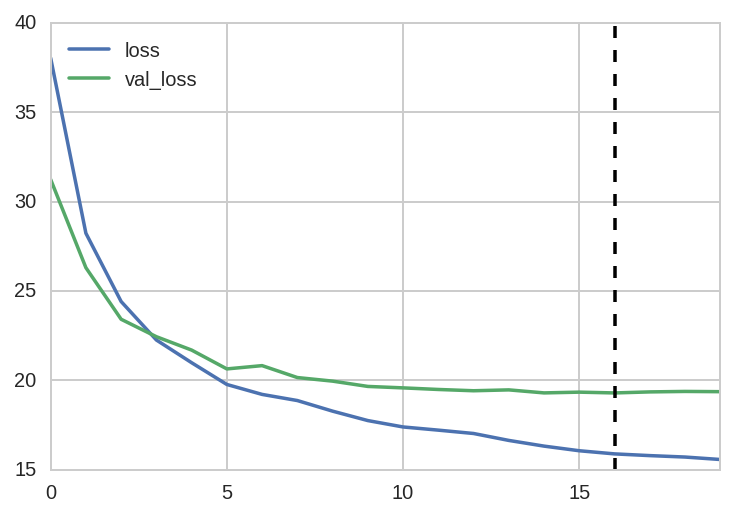

,loss,val_loss
0,38.050375,31.249202
1,28.237904,26.307415
2,24.413294,23.419551
3,22.258238,22.442736
4,20.986619,21.693549
5,19.767221,20.638794
6,19.211026,20.822668
7,18.867479,20.155217
8,18.273522,19.954648
9,17.745829,19.657878


In [55]:
plot_losses_and_metrics(hist)

## Inference

In [56]:
# Extract encoder
encoder = Model(X, encode(X, X_embed_layer, lstm_pre_attn))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 256)           2173184   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 20, 128), (None,  197120    
Total params: 2,370,304
Trainable params: 2,370,304
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Extract decoder
a_enc = Input(shape=(max_len, hidden_size_enc), name='a_enc')
s_dec_prev = Input(shape=(hidden_size_dec, ), name='s_dec_prev')
c_dec_prev = Input(shape=(hidden_size_dec, ), name='c_dec_prev')
d_in = Input(shape=(1, ), name='d_in')

decoder = Model([a_enc, s_dec_prev, c_dec_prev, d_in], one_step_decode(a_enc, s_dec_prev, c_dec_prev, d_in))
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s_dec_prev (InputLayer)         (None, 128)          0                                            
__________________________________________________________________________________________________
a_enc (InputLayer)              (None, 20, 128)      0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 128)      0           s_dec_prev[0][0]                 
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20, 256)      0           a_enc[0][0]                      
                                                                 repeat_vector_1[20][0]           
__________

In [72]:
def decode_sequence(input_seqs):
    # Generate encoder output
    a_enc_pred, s_enc_pred, c_enc_pred = encoder.predict(input_seqs)

    # Generate decoder output, one timestep at a time
    outputs_pred = []
    d_in_pred = np.array([y_stoi[GO]] * len(input_seqs)).reshape(-1, 1)
    s_dec_pred = s_enc_pred
    c_dec_pred = c_enc_pred

    for t in range(max_len):
        s_dec_pred, c_dec_pred, d_out_pred = decoder.predict([a_enc_pred, s_dec_pred, c_dec_pred, d_in_pred])

        # Derive the predicted token
        d_out_pred = d_out_pred.argmax(axis=-1)

        outputs_pred.append(d_out_pred)

        # Assign the predicted token as the next decoder input
        d_in_pred = d_out_pred

    # Convert output index into tokens
    output_seqs = np.array(y_itos)[np.array(outputs_pred).transpose()]
    
    # Clean up and output
    output_seqs = [detok(toks) for toks in output_seqs]
    
    return output_seqs

# Convert to strings and clean up
detokenizer = Detok()

def detok(toks):
    # Cut before the first padding (if any)
    toks = list(toks)
    if PAD in toks:
        first_pad = toks.index(PAD)
        toks = toks[:first_pad]
    
    return detokenizer.detokenize(toks)

In [74]:
# Test inference with validation data
y_val_pred = decode_sequence(X_ix_val)
len(y_val_pred)

30866

In [116]:
# Print out a few results
for i in range(5):
    print(i)
    print('Input:\t\t' + detok(X_val[i]))
    print('Predicted:\t' + y_val_pred[i])
    print('True:\t\t' + detok(y_val[i]))

0
Input:		tom said my plan wouldn't work.
Predicted:	tom a dit que son travail ne m'a pas pu se.
True:		tom a dit que mon plan ne fonctionnera pas.
1
Input:		a watered down compromise resolution is better than none at all.
Predicted:	un _unk_ _unk_ est plus petit que _unk_ tous les sera.
True:		une résolution sur un compromis restreint est préférable à rien du tout.
2
Input:		could i get one more beer, please?
Predicted:	pourrais - je avoir une plus de bière, s'il vous plaît?
True:		pourrais - je avoir une bière supplémentaire, je vous prie?
3
Input:		i want to ask you one simple question.
Predicted:	je veux vous poser une question une pas enfant!
True:		je veux te poser une simple question.
4
Input:		i can't stand to see animals be teased.
Predicted:	je ne peux voir pas de _unk_ des _unk_ de voir des _unk_.
True:		je ne supporte pas de voir des animaux être taquinés.


## Test loading models in a new session

In [6]:
# Load trained model
model = load_model(os.path.join(model_path, 'translate-keras.h5'), custom_objects={'softmax_axis_1': softmax_axis_1, 't': 0})

In [15]:
# Extract encoder
X = Input(shape=(max_len, ), name='X')
encoder = Model(X, encode(X, model.get_layer('embedding_1'), model.get_layer('lstm_1')))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 256)           2173184   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 20, 128), (None,  197120    
Total params: 2,370,304
Trainable params: 2,370,304
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Extract decoder
hidden_size_enc = 128
hidden_size_dec = 128
a_enc = Input(shape=(max_len, hidden_size_enc), name='a_enc')
s_dec_prev = Input(shape=(hidden_size_dec, ), name='s_dec_prev')
c_dec_prev = Input(shape=(hidden_size_dec, ), name='c_dec_prev')
d_in = Input(shape=(1, ), name='d_in')

repeator_attn = model.get_layer('repeat_vector_1')
concatenator_attn = model.get_layer('concatenate_1')
densor_attn = model.get_layer('dense_1')
activator_attn = model.get_layer('attention_weights')
dotor_attn = model.get_layer('context')

y_embed_layer = model.get_layer('embedding_2')
concatenator_post_attn = model.get_layer('concatenate_2')
lstm_post_attn = model.get_layer('lstm_2')
densor_post_attn = model.get_layer('dense_2')

decoder = Model([a_enc, s_dec_prev, c_dec_prev, d_in], one_step_decode(a_enc, s_dec_prev, c_dec_prev, d_in))
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s_dec_prev (InputLayer)         (None, 128)          0                                            
__________________________________________________________________________________________________
a_enc (InputLayer)              (None, 20, 128)      0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 128)      0           s_dec_prev[0][0]                 
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20, 256)      0           a_enc[0][0]                      
                                                                 repeat_vector_1[20][0]           
__________

In [34]:
# Test inference with validation data
y_val_pred_head = decode_sequence(X_ix_val[:5])

In [36]:
for p in y_val_pred_head:
    print(p)

tom a dit que son plan n'était pas partie.
un _unk_ _unk_ est _unk_ de ne plus que tous les _unk_.
puis - je avoir une bière, s'il vous plaît?
je veux vous poser une question une qui te sens.
je ne peux pas voir avec les femmes qui se sont _unk_.
